### **Imports, Constants and Configurations:**

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from joblib import dump

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
CON_CMAP = sns.cubehelix_palette(start=-1.5, rot=.5, as_cmap=True)
NON_STR_COLS = [
    'budget', 'popularity', 'runtime', 'vote_average',
    'vote_count', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
    'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery',
    'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western',
    'language_code', 'status_code', 'year', 'month', 'day', 'actor_1_code',
    'actor_2_code', 'actor_3_code', 'actor_4_code', 'actor_5_code', 'production_company_code',
]
CREW_COLS = [
    'actor_1_code', 'actor_2_code', 'actor_3_code',
    'actor_4_code', 'actor_5_code', 'production_company_code',
]
GENRE_COLS = [
    'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama',
    'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery',
    'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western'
]
NON_GENRECREW_COLS = list(set(NON_STR_COLS) - set(GENRE_COLS) - set(CREW_COLS))

NON_GENRE_COLS = list(set(NON_STR_COLS) - set(GENRE_COLS))

NUMERICAL_COLS = list(set(NON_GENRECREW_COLS) - set(['language_code', 'status_code']))
LABEL_ENC_COLS = CREW_COLS + ['language_code', 'status_code']

In [3]:
warnings.filterwarnings('ignore')

### **Loading Data:**

In [4]:
movie_df = pd.read_csv("./data/movies_data.csv").rename(columns={'Unnamed: 0': 'ID'})

movie_df['original_language'] = movie_df['original_language'].astype('category')
movie_df['status'] = movie_df['status'].astype('category')
movie_df['actor_name_1'] = movie_df['actor_name_1'].astype('category')
movie_df['actor_name_2'] = movie_df['actor_name_2'].astype('category')
movie_df['actor_name_3'] = movie_df['actor_name_3'].astype('category')
movie_df['actor_name_4'] = movie_df['actor_name_4'].astype('category')
movie_df['actor_name_5'] = movie_df['actor_name_5'].astype('category')
movie_df['production_company_name'] = movie_df['production_company_name'].astype('category')

### **Target Definition:**

In [5]:
movie_df['profitable'] = movie_df['profit_rate'].apply(lambda x: True if x > 1 else False)

### **Feature Scaling and Normalization:**

#### Normalizing Numerical Features:

In [6]:
scaler = StandardScaler()
num_cols = ['revenue'] + NUMERICAL_COLS
movie_df[num_cols] = scaler.fit_transform(movie_df[num_cols])

dump(scaler, './models/numerical_scaler.joblib')

['./models/numerical_scaler.joblib']

#### Scaling All Features:

In [7]:
scaler = MinMaxScaler()

movie_df[NON_GENRECREW_COLS] = scaler.fit_transform(movie_df[NON_GENRECREW_COLS])

dump(scaler, './models/label_scaler.joblib')

['./models/label_scaler.joblib']

### **Feature Extraction:**

#### Genres:

In [8]:
pca = PCA(n_components=5)

principalComponents = pca.fit_transform(movie_df[GENRE_COLS])

dump(scaler, './models/genre_pca.joblib')

principalDf = pd.DataFrame(data = principalComponents, columns = ['genrePC1', 'genrePC2', 'genrePC3', 'genrePC4', 'genrePC5'])

### **Feature Selection:**

In [9]:
x = movie_df[NON_GENRE_COLS]
y = movie_df['profitable']

selector = SelectKBest(f_classif, k=10)
X_new = selector.fit_transform(x, y)

cols = selector.get_support(indices=True)
selected_features_df = x.iloc[:,cols]

### **Mixing All Features Together:**

In [10]:
final_df = pd.concat([selected_features_df, principalDf , movie_df['profitable']], axis = 1)
final_df.columns

Index(['popularity', 'runtime', 'year', 'language_code', 'vote_average',
       'budget', 'vote_count', 'month', 'actor_5_code',
       'production_company_code', 'genrePC1', 'genrePC2', 'genrePC3',
       'genrePC4', 'genrePC5', 'profitable'],
      dtype='object')

### **Modeling:**

#### Prepare train/test sets:

In [11]:
target = 'profitable'
features = [col for col in final_df.columns if col != target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(final_df[features], final_df[target], test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Logistic Regression:

              precision    recall  f1-score   support

       False       0.75      0.86      0.80       446
        True       0.84      0.72      0.77       459

    accuracy                           0.79       905
   macro avg       0.79      0.79      0.79       905
weighted avg       0.79      0.79      0.79       905



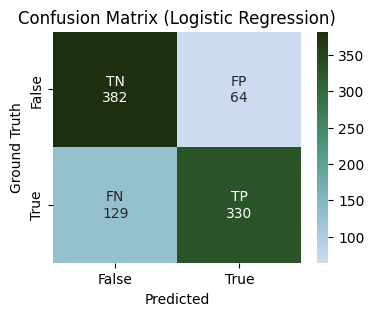

In [12]:
# Initialize the Logistic Regression model
LR_model = LogisticRegression()

# Fit the LR_model on the training data
LR_model.fit(X_train, y_train)

# Make predictions on the testing data
predictions = LR_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, predictions))

conf_matrix = confusion_matrix(y_test, predictions)

labels = ['TN', 'FP', 'FN', 'TP']
labels = np.asarray(labels).reshape(2,2)

labels_val = (np.asarray(["{0}\n{1}".format(label, val) for label, val in zip(labels.flatten(), conf_matrix.flatten())])).reshape(2,2)

plt.figure(figsize=(4,3))
sns.heatmap(conf_matrix, annot=labels_val, fmt='', cmap=CON_CMAP)
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix (Logistic Regression)")

plt.xticks([0.5, 1.5], ['False', 'True'])
plt.yticks([0.5, 1.5], ['False', 'True'])

plt.show()

#### Decision Tree:

              precision    recall  f1-score   support

       False       0.79      0.76      0.77       446
        True       0.77      0.80      0.79       459

    accuracy                           0.78       905
   macro avg       0.78      0.78      0.78       905
weighted avg       0.78      0.78      0.78       905



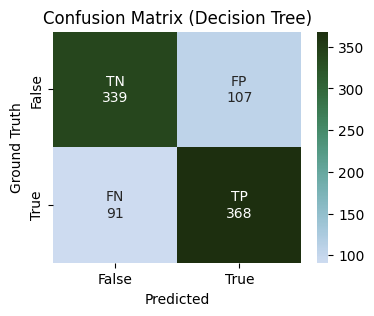

In [13]:
# Initialize the Decision Tree model
DT_model = DecisionTreeClassifier()

# Fit the DT_model on the training data
DT_model.fit(X_train, y_train)

# Make predictions on the testing data
predictions = DT_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, predictions))

conf_matrix = confusion_matrix(y_test, predictions)

labels = ['TN', 'FP', 'FN', 'TP']
labels = np.asarray(labels).reshape(2,2)

labels_val = (np.asarray(["{0}\n{1}".format(label, val) for label, val in zip(labels.flatten(), conf_matrix.flatten())])).reshape(2,2)

plt.figure(figsize=(4,3))
sns.heatmap(conf_matrix, annot=labels_val, fmt='', cmap=CON_CMAP)
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix (Decision Tree)")

plt.xticks([0.5, 1.5], ['False', 'True'])
plt.yticks([0.5, 1.5], ['False', 'True'])

plt.show()


#### Random Forest:

              precision    recall  f1-score   support

       False       0.83      0.83      0.83       446
        True       0.83      0.84      0.83       459

    accuracy                           0.83       905
   macro avg       0.83      0.83      0.83       905
weighted avg       0.83      0.83      0.83       905



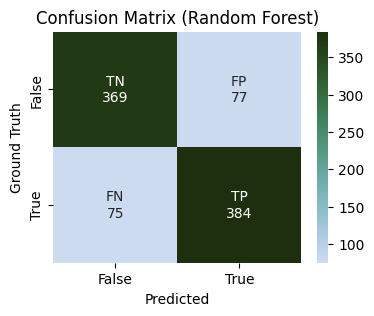

In [14]:
# Initialize the Random Forest model
RF_model = RandomForestClassifier()

# Fit the RF_model on the training data
RF_model.fit(X_train, y_train)

# Make predictions on the testing data
predictions = RF_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, predictions))

conf_matrix = confusion_matrix(y_test, predictions)

labels = ['TN', 'FP', 'FN', 'TP']
labels = np.asarray(labels).reshape(2,2)

labels_val = (np.asarray(["{0}\n{1}".format(label, val) for label, val in zip(labels.flatten(), conf_matrix.flatten())])).reshape(2,2)

plt.figure(figsize=(4,3))
sns.heatmap(conf_matrix, annot=labels_val, fmt='', cmap=CON_CMAP)
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix (Random Forest)")

plt.xticks([0.5, 1.5], ['False', 'True'])
plt.yticks([0.5, 1.5], ['False', 'True'])

plt.show()


#### XGBoost:

              precision    recall  f1-score   support

       False       0.85      0.81      0.83       446
        True       0.82      0.86      0.84       459

    accuracy                           0.84       905
   macro avg       0.84      0.84      0.84       905
weighted avg       0.84      0.84      0.84       905



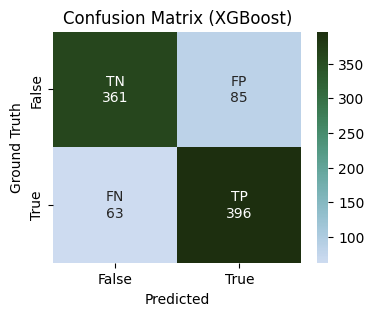

In [15]:
# Initialize the XGBoost model
XGB_model = XGBClassifier(use_label_encoder=False)

# Fit the XGB_model on the training data
XGB_model.fit(X_train, y_train)

# Make predictions on the testing data
predictions = XGB_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, predictions))

conf_matrix = confusion_matrix(y_test, predictions)

labels = ['TN', 'FP', 'FN', 'TP']
labels = np.asarray(labels).reshape(2,2)

labels_val = (np.asarray(["{0}\n{1}".format(label, val) for label, val in zip(labels.flatten(), conf_matrix.flatten())])).reshape(2,2)

plt.figure(figsize=(4,3))
sns.heatmap(conf_matrix, annot=labels_val, fmt='', cmap=CON_CMAP)
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix (XGBoost)")

plt.xticks([0.5, 1.5], ['False', 'True'])
plt.yticks([0.5, 1.5], ['False', 'True'])

plt.show()


#### Saving All Models:

In [16]:
dump(LR_model, './models/logistic_regression_model.joblib')
dump(DT_model, './models/decision_tree_model.joblib')
dump(RF_model, './models/random_forest_model.joblib')
dump(XGB_model, './models/xgboost_model.joblib')

['./models/xgboost_model.joblib']